# Bolidozor vs optical trajectories - correlation example

**Pred prvnim spustenim inicializujte funkce a importujte moduly, které jsou na konci tohoto notebooku

také musí být na počítači nainstalováni MLABvoClient '''sudo pip3 install MLABvo'''



## jak to celé má fungovat?
(současný stav)

 * Vybrat shodu, ručně určit přibližně dráhu (zatím přesně)
 * Získat jednu shodu
 * Určit časový offset u každé detekce + stanovit nejmenší a největší čas ze všech dat.
 * Nepřesně určit dopplera pro dráhu + najít 'nulu' pro každou detekci
 * dopplera pro dráhu zpřesnit na úroveň vzorku v rozmezí n s od extrémních časů minim nulových dopplerů (tzn. reálných headeach)
 * Z dopplera vygenerovat signál
 * 
 * 
 * ....

# Events

jednotlivé události meteorů. Obsahují ID z bolidozoru a reálnou trajektorii...

In [ ]:
if False:#2057410
    multibolid_id = 2057410
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([44980.37638663])

    met_stop_lat = np.array([48.340593635025])
    met_stop_lon = np.array([6.572188010297])

    met_start_lat = np.array([49.52717828089])
    met_start_lon = np.array([6.763558272451])
    
    met_velocity = [45500]
    model_offset = -8.25

In [ ]:
if False:#2047621
    multibolid_id = 2047621
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([41896.884619396])

    met_start_lat = np.array([49.997439391249])
    met_start_lon = np.array([9.692504979925])

    met_stop_lat = np.array([50.035327181108])
    met_stop_lon = np.array([7.560013628387])

    met_velocity = [24500]
    model_offset = 1.44

In [24]:
if True:#2017388
    multibolid_id = 2017388
    met_start_altitude = np.array([55000.0])
    met_stop_altitude = np.array([8910.7633450924])

    met_stop_lon = np.array([6.512636353428])
    met_stop_lat = np.array([51.944553218498])
    
    met_start_lon = np.array([9.996094184309])
    met_start_lat = np.array([51.230870109095])

    met_velocity = [30500]
    model_offset = 7.94

In [25]:
geoC = Geocentric(6378137, 6356752.314)
stations = {}
stations['SVAKOV-R12']={'name': 'SVAKOV','latitude':49.2607,'longitude':14.6917,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['ZVPP-R6']={'name': 'ZVPP','latitude':48.9869,'longitude':14.4675,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['HFN-R1']={'name': 'JHRADEC','latitude':49.1314,'longitude': 14.9999,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['VALMEZ-R1']={'name': 'VALMEZ','latitude':49.463038,'longitude': 17.973544,'elevation':400, 'status': 'testing', 'type': 'receiver'}
stations['DDMTREBIC-R3']={'name': 'TREBIC','latitude':49.2071,'longitude':15.8759,'elevation':480, 'status': 'operational', 'type': 'receiver'}

c = scipy.constants.c
trans_station_point = np.array(geoC.GeographicToGeocentric(47.347993, 5.515079, 190))
t = 0.005
t = 1/96000
t = 1/96000*1000

timesteps = np.arange(-20,5,t)

In [ ]:
bz = MLABvo.Bolidozor.Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)

# Časové zarovnání

Následující blok najde GPS značky v RAW souborech a k navrácené hodnotě z bolidozoru přidá informace o offsetu a zkalibrovaný čas. Tato data je pak možné dále používat. Na konci to vykreslí zarovnaný průběh signálu v čase.


 0 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_raws.fits
delka zaznamu          : 17.6 s
cas prvni. vzorku s GPS: 6.144463541666667 s
cas 1. GPS a konec     : 11.455536458333334 s
SysCas ukladani souboru: 2017-11-11 18:02:09 s
SysCas zacatku souboru : 2017-11-11 18:01:51.400000
SysCas 1. GPS znacky   : 2017-11-11 18:01:57.544464
Korekce systemoveho cas: 0:00:02.455536
Korekce casu zvukovky  : 47.39746403694153
CorCas ukladani souboru: 2017-11-11 18:02:11.455536 s
CorCas zacatku souboru : 2017-11-11 18:01:53.855536
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Pocet vzorku s gps znac: 3863


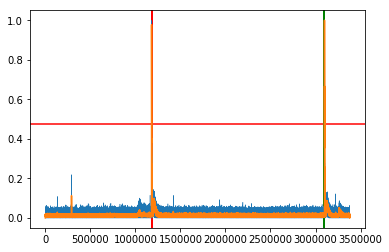


 1 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/11/11/18/20171111180205537_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/11/11/18/20171111180205537_DDMTREBIC-R3_raws.fits
delka zaznamu          : 13.4 s
cas prvni. vzorku s GPS: 5.914083333333333 s
cas 1. GPS a konec     : 7.485916666666667 s
SysCas ukladani souboru: 2017-11-11 18:02:06 s
SysCas zacatku souboru : 2017-11-11 18:01:52.600000
SysCas 1. GPS znacky   : 2017-11-11 18:01:58.514083
Korekce systemoveho cas: 0:00:01.485917
Korekce casu zvukovky  : 11.451082944869995
CorCas ukladani souboru: 2017-11-11 18:02:07.485917 s
CorCas zacatku souboru : 2017-11-11 18:01:54.085917
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Pocet vzorku s gps znac: 1237


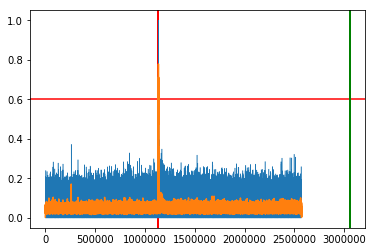


 2 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/11/11/18/20171111180154354_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/11/11/18/20171111180154354_HFN-R1_raws.fits
delka zaznamu          : 18.399989583333333 s
cas prvni. vzorku s GPS: 5.810583333333334 s
cas 1. GPS a konec     : 12.58940625 s
SysCas ukladani souboru: 2017-11-11 18:02:11 s
SysCas zacatku souboru : 2017-11-11 18:01:52.600010
SysCas 1. GPS znacky   : 2017-11-11 18:01:58.410594
Korekce systemoveho cas: 0:00:01.589406
Korekce casu zvukovky  : 0.16458415985107422
CorCas ukladani souboru: 2017-11-11 18:02:12.589406 s
CorCas zacatku souboru : 2017-11-11 18:01:54.189416
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Pocet vzorku s gps znac: 3740


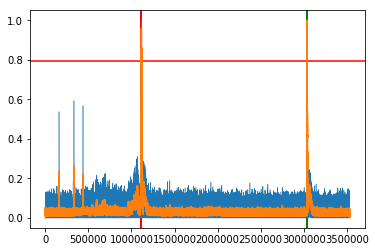

In [26]:
%matplotlib inline
for i, bolid in enumerate(bolids.result):
    try:
        print("\n", i,"==================================\n", "snapshot:", bolid['url_file_js9'])
        bolids.result[i]['time_calib']=MLABvo.Bolidozor.timeCalibration(bolid['url_file_raw'], bolid['station_name'])
    except Exception as e:
        print("ERROR, bolids.result:", e)

Zde se vybegou všechny meteory ze shody

In [27]:
selected = list(range(0, len(bolids.result)))
time_offset = {}

Tento blok zjišťuje čas prvního vzorku na všech detekcích a čas posledního. Navíc to vykreslí graf znázorňující jednotlivé signály posunuté podle zjištěného offsetu

0 2017-11-11 18:01:53.855536 SVAKOV-R12
1 2017-11-11 18:01:54.085917 DDMTREBIC-R3
2 2017-11-11 18:01:54.189416 HFN-R1
zpozdeni obrazku 0.0
zpozdeni obrazku 22117.0
zpozdeni obrazku 32052.0
1510423313.855536 1510423332.589406


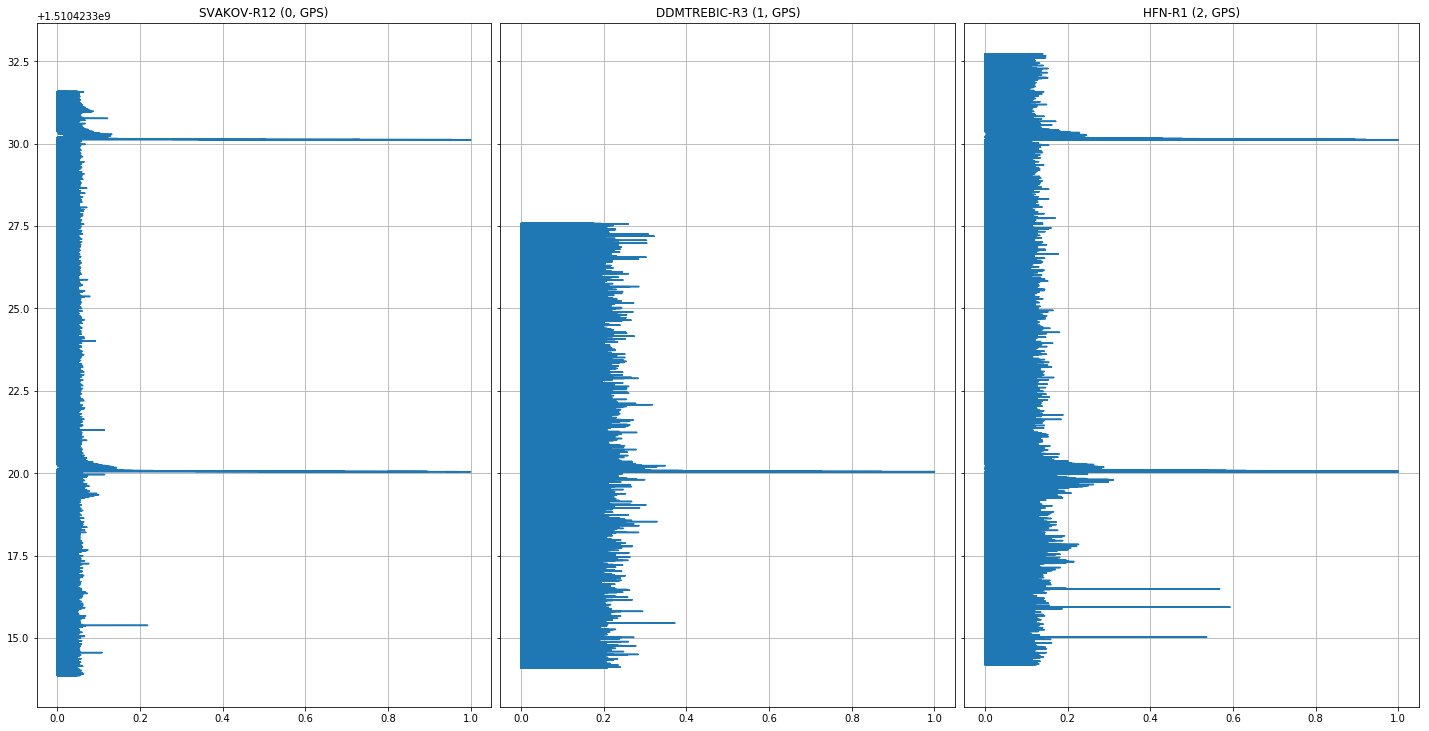

In [28]:
%matplotlib inline
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    try:
        bolid = bolids.result[selected[i]]
        print (i, bolid['time_calib']['cor_file_beg'], bolid['namesimple'])
        hdulist = fits.open(bolid['url_file_raw'])
        met_data = np.abs(np.ravel(hdulist[0].data))

        T_offset = 10*time_offset.get(selected[i], 0)

        if gps_calib:
            ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
            min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            bolid['time_calib']['time_range']=[min_date, max_date]
        else:
            ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
            min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            bolid['time_calib']['time_range']=[min_date, max_date]
        #array = np.arange(min_date, max_date, 1/96000/2)
        array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))

        if not minimal_time: minimal_time = min_date
        if not maximal_time: maximal_time = max_date
        if min_date < minimal_time: minimal_time = min_date
        if max_date > maximal_time: maximal_time = max_date

        ax.plot(met_data, array)
        ax.grid(True)
    except Exception as e:
        print(e)

del min_date # dale pouzivat minimal_time
del max_date

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    T_offset = 10*time_offset.get(selected[i], 0)
    time_range = bolid['time_calib']['time_range']
    image_offset = time_range[0] - minimal_time + T_offset
    print("zpozdeni obrazku", np.round(image_offset*96000))
    bolid['time_calib']['sample_offset']=np.round(image_offset*96000)

fig.subplots_adjust(wspace=0.02, left = 0.02, right=0.98,bottom=0.02, top=0.97)
print(minimal_time, maximal_time)
plt.show()

Nyní je potřeba zkontrolovat, jestli předchozí algoritmus RAW data zarovnal správně. To lze zjistit podle GPS značek, že se nachází ve stejném čase. 

---

Tato funkce najde čas (oproti vygenerované trajktorii), kde je nulový vektor radiální rychlosti. Tento bod to zjistí pro každou detekci Následně to spočítá doplera v blízkém okolí extrémů nulového dopplera s vysokým rozlišením (odpovídajcímu vzorkovací frekvenci).

V druhé části to pro každý RAW záznam vygeneruje dopplera a pak ho převede na signál dopplera

vytvori se promenna '''doppler_list''', která bude obsahovat pocet sloupcu odpovidajici poctu detekci. V kazde bude odpovidajici doppler (s vysokym rozlisenim)

probehl vypocet dopplera s malym rozlisenim, casy jsou -6.8 az -5.9.


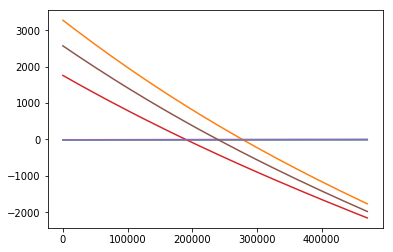

In [29]:
%matplotlib inline

timesteps = np.arange(-30,30,0.1)
dopplers_null = []

# vypocet dopplera s malym rozlisenim (jen pro urceni nuloveho posunu)
for meteor in selected:
    bolid = bolids.result[selected[meteor]]
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
    station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))
    met_points = generate_path(met_start_point, met_stop_point, met_velocity[0], timesteps)
    doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, station_point)
    
    doppler_zero_index = np.argmin(np.abs(doppler[:,1]))
    doppler_zero_time = doppler[doppler_zero_index][0]
    dopplers_null.append([doppler_zero_time])   
    
print("probehl vypocet dopplera s malym rozlisenim, casy jsou %s az %s." %(np.min(dopplers_null), np.max(dopplers_null)))

okoli = 2   ## Jake okoli nuloveho dopplera generovat v [s]
timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 1/96000)

# vypocet dopplera s vysokym rozlisenim (pro presne urceni dopplera v okamzik nulove radialni rychlosti)
for meteor in selected:
    bolid = bolids.result[selected[meteor]]

    # prevedou se souradnice do kartezke soustavy a nasledne se spocita trajektorie (vektor) meteoru
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
    station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))
    met_points = generate_path(met_start_point, met_stop_point, met_velocity[0], timesteps)

    # Vytvoreni modelu head-echa (dopplerovsky posuv modelu) 
    doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, station_point)
    
    # zapise se index bodu simulace, kde je dopplerovsky posuv nulovy
    bolids.result[selected[meteor]]['doppler_zero_index'] = np.argmin(np.abs(doppler[:,1])) # doppler zero index (index, kde je nejmensi dopplerovsky posuv)
    
    # Prevod dopplerovsych frekvenci na signal
    # !!! Nejsem si jist, jestli toto provadim spravne
    dt = timesteps[1]-timesteps[0]
    signal = (np.sin(2*np.pi*dt*np.cumsum(np.interp(np.arange(len(doppler)), doppler[:,0], doppler[:, 1]))))
    
    #zapsat signal dopplera a frekvence dopplera k meteoru
    bolids.result[selected[meteor]]['doppler_signal'] = signal
    bolids.result[selected[meteor]]['doppler_frequency'] = doppler
    plt.plot(doppler)

plt.show()

Dále se vezme signál a bude se hledat nejlepší korelace.

delka meteoru je 1689600 vzorků a delka vygenerovaneho dopplera je na indexu 470401 vzorku. Vzorek s nulovym dopplerem oproti modelu je 277324


/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


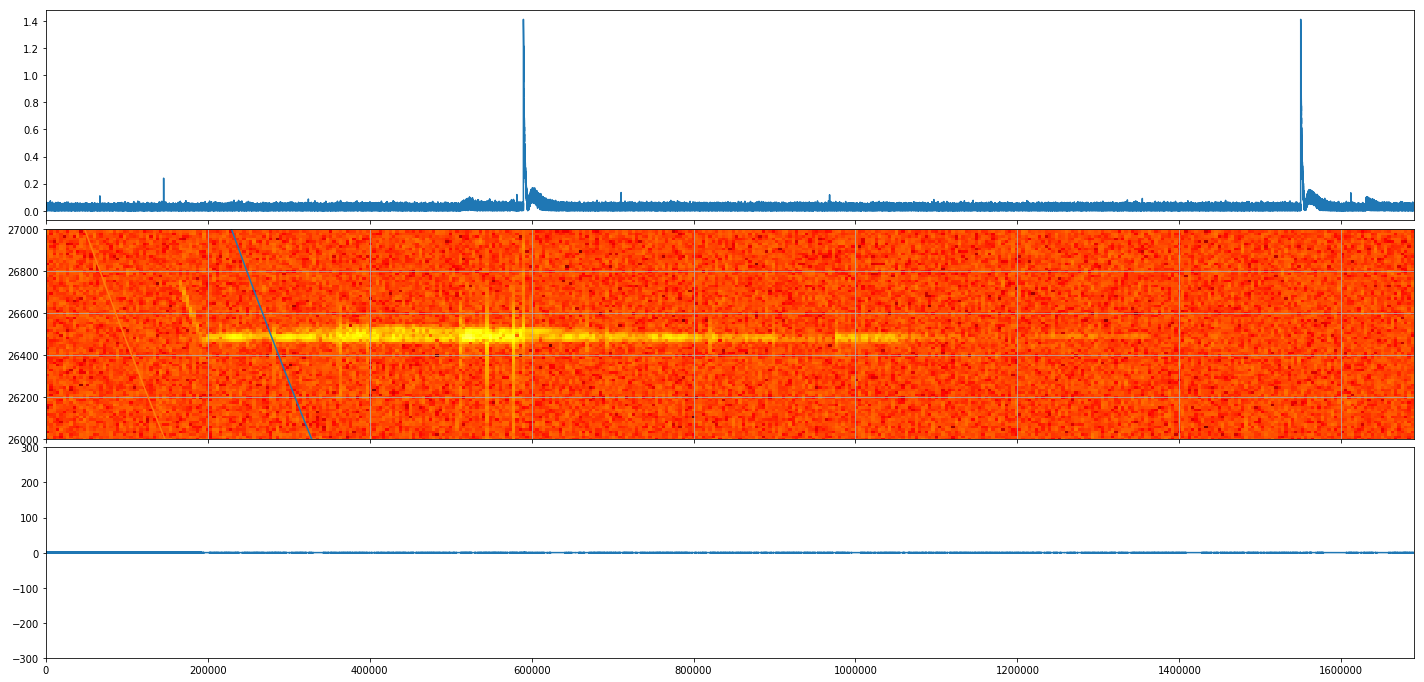

In [31]:
#np.appen
surround = 1

#for meteor in selected:
if True: # tady pak bude for pro vsechny stanice
    meteor = 0
    bolid = bolids.result[selected[meteor]]
    hdulist = fits.open(bolid['url_file_raw'])
    raw = hdulist[0].data[:,0] + hdulist[0].data[:,1] * 1j
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
    
    print("delka meteoru je", raw.shape[0], 'vzorků a delka vygenerovaneho dopplera je na indexu', bolid['doppler_signal'].shape[0], 'vzorku. Vzorek s nulovym dopplerem oproti modelu je', repr(bolid['doppler_zero_index']))
    
    doppler = bolid['doppler_frequency']
    doppler_signal = np.empty_like(raw)
    doppler_freq_c = bolid['doppler_signal'][int(bolid['doppler_zero_index']-surround*96000):int(bolid['doppler_zero_index']+surround*96000)]
    np.put(doppler_signal, np.arange(len(doppler_freq_c)), doppler_freq_c, mode='crop')

    cor = scipy.signal.correlate(raw, doppler_signal, 'same')

    l1 = range(len(raw.real))
    l2 = range(len(doppler[1:,0][96000*2:]))

    ax1.plot(np.abs(raw))
    ax1.set_xlim(0,len(raw.real))

    arr = waterfall(raw, None, bins = 4096*2)
    ax2.imshow(arr.T,  interpolation='none', aspect='auto',  extent=[0, len(raw.real),48000, -48000], cmap=plt.get_cmap('hot'))
    ax2.grid(True)
    ax2.set_ylim(13000*2,13500*2)
    ax2.plot(np.arange(1, len(doppler[:,1])), doppler[1:,1]+26500.0)
    ax2.plot(np.arange(0, len(2+doppler[:,1][int(bolid['doppler_zero_index']-surround*96000):int(bolid['doppler_zero_index']+surround*96000)]))+0, doppler[1:,1][int(bolid['doppler_zero_index']-surround*96000):int(bolid['doppler_zero_index']+surround*96000)]+26500.0)


   
    ax3.plot(doppler_signal)
    ax3.set_ylim(-300,300)
    fig.subplots_adjust(wspace=0.04, hspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)

Na předchozí blok lze navázat. Jsou tam obsažena všechna potřebná data - RAW signál, začátek RAW souboru, doppler, signál dopplera

# stare kody a ruzne pokusy  - ted uz asi casto nefunkcni

In [ ]:
##
##
##
##

%matplotlib tk

meteor = 0

bolid = bolids.result[selected[meteor]]
hdulist = fits.open(bolid['url_file_raw'])
raw = hdulist[0].data[:,0] + hdulist[0].data[:,1] * 1j

if gps_calib:
    #ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
    min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
else:
    #ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
    min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))


met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))


In [ ]:
print('met_points', met_points)
print('timpstaps', timesteps)
print('rec_station_point', rec_station_point)
print('trans_station_point', trans_station_point)

doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, rec_station_point)
doppler_zero_index = np.argmin(np.abs(doppler[:,1]))
doppler_zero_time = doppler[doppler_zero_index][0]

dopp_time = np.vectorize(lambda x: dates.date2num(d1+datetime.timedelta(seconds=(x)+model_offset)))
dopp_freq = np.vectorize(lambda x: ((x)+26500.0))

print(raw)
print(doppler)
print("doppler_zero_time", doppler_zero_time, "@", doppler_zero_index)



In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
sample_offset = -doppler_zero_index + int(96000*(1.6706))
#sample_offset = -doppler_zero_index + int(96000*(-2.479))  #asi optimalni
#sample_offset = -doppler_zero_index + int(96000*(-2))
#sample_offset = -doppler_zero_index + int(96000*(-1))
#sample_offset = -doppler_zero_index + int(96000*(0))


x = np.arange(len(doppler[1:,1]))
#y = 1*np.sin(2 * np.pi * doppler[1:,1] * x / 96000)
#y = 1*np.sin(2 * np.pi * freq * x / sr)


korekce = np.add.accumulate(len(doppler[1:,1])*np.concatenate((np.zeros(1), 2*np.pi*(doppler[1:,1][:-1]-doppler[1:,1][1:]))))
y = np.sin(2*np.pi*doppler[1:,1]*len(doppler[1:,1]))*10
#y2= np.sin(2*np.pi*doppler[1:,1]*len(doppler[1:,1]))

doppler_signal = np.zeros_like(raw)
np.put(doppler_signal, np.arange(1, len(y))+sample_offset, y, mode='crop')

print(doppler_signal)
print(raw)
print("dopplerTime")
print(doppler[1:,0])

cor = scipy.signal.correlate(raw, doppler_signal, 'same')

l1 = range(len(raw.real))
l2 = range(len(doppler[1:,0][96000*2:]))

#ax1.plot(l1, doppler_signal.real, l1, cor.imag)
ax1.plot(l1, raw.real, l1, raw.imag)
ax1.set_xlim(0,len(raw.real))


arr = waterfall(raw, None, bins = 4096*2)
ax2.imshow(arr.T,  interpolation='none', aspect='auto',  extent=[0, len(raw.real),48000, -48000], cmap=plt.get_cmap('hot'))
ax2.grid(True)
ax2.set_ylim(13000*2,13500*2)
ax2.plot(np.arange(1, len(doppler[:,1]))+sample_offset, doppler[1:,1]+26500.0)


print("suma", np.sum(np.abs(cor)))
#ax3.plot(scipy.signal.correlate(doppler_signal, raw.real, 'same').real)
#ax3.plot(cor)
#ax3.plot(scipy.signal.convolve(raw.real, doppler_signal, 'same').real)
#ax3.plot(y2)
ax3.plot(y)
ax3.set_ylim(-300,300)
fig.subplots_adjust(wspace=0.04, hspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)




In [ ]:
con = []
for x in np.arange(1.655,1.67,10/96000):
    sample_offset = int(-doppler_zero_index + int(96000*(x)))
    doppler_signal = np.zeros_like(raw)
    np.put(doppler_signal, np.arange(1, len(y))+sample_offset, y, mode='crop')
    cor = scipy.signal.correlate(doppler_signal, raw, 'same')
    s = np.sum(np.abs(cor[96000*int(x-0.5):96000*int(x+0.5)]))
    print(x, s)
    con.append([x, s])
con = np.array(con)
print(con[:,0])
plt.plot(con[:,0], con[:,1])

In [ ]:
delp = 0
dela = 0
runc = 1 # pet nahodnych prubehu
timesteps = np.arange(-10,5,1/96000)
    
    
for runi in np.arange(runc):
    doppler_zero_index = None
    met_start_lat_rand = met_start_lat + np.random.ranf(met_start_lat.shape)*2*delp-delp
    met_start_lon_rand = met_start_lon + np.random.ranf(met_start_lon.shape)*2*delp-delp
    met_start_alt_rand = met_start_altitude + np.random.ranf(met_start_altitude.shape)*2*dela-dela
    met_stop_lat_rand = met_stop_lat + np.random.ranf(met_stop_lat.shape)*2*delp-delp
    met_stop_lon_rand = met_stop_lon + np.random.ranf(met_stop_lon.shape)*2*delp-delp
    met_stop_alt_rand = met_stop_altitude + np.random.ranf(met_stop_altitude.shape)*2*dela-dela
    met_velocity = np.random.randint(20000,50000, 1)
    
    met_points = np.empty([timesteps.size, 3])
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat_rand[0], met_start_lon_rand[0], met_start_alt_rand[0]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat_rand[0], met_stop_lon_rand[0], met_stop_alt_rand[0]))
    met_vect = met_stop_point - met_start_point
    print("meteor vector", met_vect)
    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[0]))
    print("generation of points DONE")
    

In [ ]:
#%matplotlib tk
#%matplotlib notebook
%matplotlib inline
import time


if True:
    #
    #  tady zacne for pro kazdou stanici
    #
    for meteor in np.arange(3):
        con = []
        bolid = bolids.result[selected[meteor]]
        hdulist = fits.open(bolid['url_file_raw'])
        raw = hdulist[0].data[:,0] + hdulist[0].data[:,1] * 1j
    
        rec_station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                     stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))

        #doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, rec_station_point)
        doppler = bolid['doppler']
        x = np.arange(len(doppler)-1)
        y = 1*np.sin(2 * np.pi * doppler[1:,1] * x / 96000)
        if not doppler_zero_index:
            doppler_zero_index = np.argmin(np.abs(doppler[:,1][1:-1]))+1
            doppler_zero_time = doppler[doppler_zero_index][0]
        #print(bolid['namesimple'])
        
        
        for dtime in np.arange(1,7,1/96000*2000):
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
            ax1.plot(raw.real)
            ax1.plot(doppler)
            doppler_signal = np.zeros_like(raw)
            zeroi = doppler_zero_index+int(dtime*69000)
            np.put(doppler_signal, np.arange(1, len(y))-doppler_zero_index+int(dtime*69000), y, mode='crop')
            ax2.plot(doppler_signal.real)
            #plt.show()
            #time.sleep(10)
            cor = scipy.signal.correlate(doppler_signal, raw, 'same')
            ax3.plot(cor.real)
            plt.savefig(bolid['namesimple']+str(dtime)+".png")
            plt.close()
            s = np.sum(np.abs(cor[int((dtime-0.5)*69000):int((dtime+0.5)*69000)]))/1e4
            print(dtime, s)
            con.append([dtime, s])
        con = np.array(con)
        print(bolid['namesimple'], "tahle stanice byla zpracovana")
        plt.plot(con[:,0], con[:,1], label=bolid['namesimple'])
        


#
# Inicializace

K inicializaci před prvnim spustenim:

In [20]:
import MLABvo.Bolidozor
import MLABvo.BolidozorTools
import numpy as np
import scipy, scipy.constants
import scipy, scipy.signal
from Geocentric import Geocentric
import matplotlib.pyplot as plt
from astropy.io import fits
import datetime
from matplotlib import dates
import recviewer

In [21]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    #wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

In [22]:
def estimate_dopplers2(trajectory, timesteps, f0, trans_station, rec_station):
    # alternative algorithm
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
   
    doppler = np.empty([trajectory.shape[0], 2])
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        try: 
            # angle transmitter - meteor - reciever
            ba = trans_station-trajectory[i]
            bc = rec_station-trajectory[i]
            TMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))

            # angle trajectory - meteor - reciever
            ba = trajectory[i+1]-trajectory[i]
            bc = rec_station-trajectory[i]
            VMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))
            # angle trajectory - meteor - axis (of angle transmitter-meter-reciever)
            VMA = VMR-TMR/2
            #print(np.degrees(VMA))

            # radial speed of meteor to axis of TMR angle (Transmitter - meteor - reciever)
            radial_speed = np.cos(VMA)*(np.linalg.norm(trajectory[i]-trajectory[i+1])/t)
            doppler_offset = (radial_speed/c)*f0
            
        except Exception as e:
            #print(e)
            pass
        
        doppler[i] = np.array([timesteps[i], doppler_offset])
    return doppler

def generate_path(start_point, stop_point, velocity, timesteps):
    points = np.empty([timesteps.size, 3])
    #start_lat, start_lon, start_alt = start
    #stop_lat, stop_lon, stop_alt = end
    #start_point = np.array(geoC.GeographicToGeocentric(start_lat, start_lon, start_alt))
    #stop_point = np.array(geoC.GeographicToGeocentric(stop_la, stop_lon, stop_alt))
    met_vect = stop_point - start_point
    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        points[i] =  start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * velocity))
    return(points)

In [23]:
estimate_doppler()

NameError: name 'estimate_doppler' is not defined